In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from math import sqrt


In [2]:
forecast_df = pd.read_csv('../data/tesla_lstm_30day_forecast.csv', parse_dates=['Date'], index_col='Date')
tsla_hist = yf.download('TSLA', start='2015-01-01', end='2025-01-01')['Close'].asfreq('B').fillna(method='ffill')
bnd_hist = yf.download('BND', start='2015-01-01', end='2025-01-01')['Close'].asfreq('B').fillna(method='ffill')
spy_hist = yf.download('SPY', start='2015-01-01', end='2025-01-01')['Close'].asfreq('B').fillna(method='ffill')


C:\Users\HP\AppData\Local\Temp\ipykernel_12248\3330465717.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tsla_hist = yf.download('TSLA', start='2015-01-01', end='2025-01-01')['Close'].asfreq('B').fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_12248\3330465717.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  bnd_hist = yf.download('BND', start='2015-01-01', end='2025-01-01')['Close'].asfreq('B').fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
C:\Users\HP\AppData\Local\Temp\ipykernel_12248\3330465717.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_hist = yf.download('SPY', start='2015-01-01', end='2025-01-01')['Close'].asfreq('B').fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed


In [7]:
# Ensure we work with Series, not DataFrames
tsla_hist_returns = tsla_hist.squeeze().pct_change().dropna()
bnd_hist_returns = bnd_hist.squeeze().pct_change().dropna()
spy_hist_returns = spy_hist.squeeze().pct_change().dropna()

# Rename and combine into a single DataFrame
hist_returns = pd.concat(
    [
        tsla_hist_returns.rename('TSLA'),
        bnd_hist_returns.rename('BND'),
        spy_hist_returns.rename('SPY')
    ],
    axis=1
).dropna()

# Preview the result
hist_returns.head()


,TSLA,BND,SPY
Date,,,
2015-01-05,-0.042041,0.002904,-0.018060
2015-01-06,0.005664,0.002895,-0.009419
2015-01-07,-0.001562,0.000603,0.012461
2015-01-08,-0.001564,-0.001564,0.017745
2015-01-09,-0.018802,0.001686,-0.008014


In [8]:
forecast_returns = forecast_df['Predicted_Close_Price'].pct_change().dropna()
expected_daily_tsla = forecast_returns.mean()
expected_annual_tsla = expected_daily_tsla * 252
expected_daily_bnd = bnd_hist_returns.mean()
expected_annual_bnd = expected_daily_bnd * 252
expected_daily_spy = spy_hist_returns.mean()
expected_annual_spy = expected_daily_spy * 252
expected_returns_annual = np.array([expected_annual_tsla, expected_annual_bnd, expected_annual_spy])


In [9]:
cov_daily = hist_returns.cov()
cov_annual = cov_daily * 252


In [10]:
n_portfolios = 50000
results = np.zeros((3 + 3, n_portfolios))
np.random.seed(42)
for i in range(n_portfolios):
    weights = np.random.random(3)
    weights /= np.sum(weights)
    port_return = np.dot(weights, expected_returns_annual)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_annual.values, weights)))
    sharpe = port_return / port_vol if port_vol != 0 else 0.0
    results[0,i] = port_return
    results[1,i] = port_vol
    results[2,i] = sharpe
    results[3:6,i] = weights
results_df = pd.DataFrame({
    'Return': results[0],
    'Volatility': results[1],
    'Sharpe': results[2],
    'w_TSLA': results[3],
    'w_BND': results[4],
    'w_SPY': results[5]
})


In [11]:
max_sharpe_idx = results_df['Sharpe'].idxmax()
min_vol_idx = results_df['Volatility'].idxmin()
max_sharpe_port = results_df.loc[max_sharpe_idx]
min_vol_port = results_df.loc[min_vol_idx]


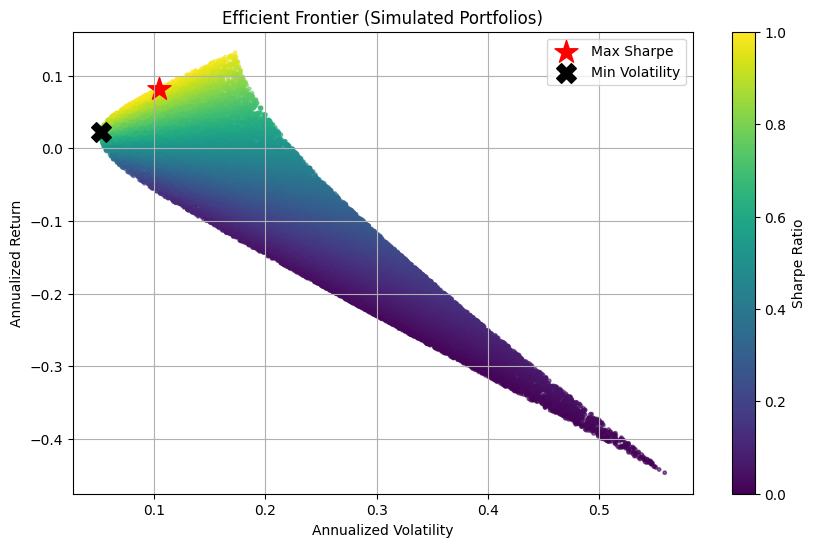

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(results_df['Volatility'], results_df['Return'], c=results_df['Sharpe'], cmap='viridis', s=6, alpha=0.6)
plt.scatter(max_sharpe_port['Volatility'], max_sharpe_port['Return'], marker='*', color='r', s=300, label='Max Sharpe')
plt.scatter(min_vol_port['Volatility'], min_vol_port['Return'], marker='X', color='k', s=200, label='Min Volatility')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Efficient Frontier (Simulated Portfolios)')
plt.colorbar(label='Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
rf = 0.0
def summary_row(row):
    w = np.array([row['w_TSLA'], row['w_BND'], row['w_SPY']])
    ret = row['Return']
    vol = row['Volatility']
    sr = (ret - rf)/vol if vol!=0 else np.nan
    return pd.Series({
        'w_TSLA': row['w_TSLA'],
        'w_BND': row['w_BND'],
        'w_SPY': row['w_SPY'],
        'Expected Annual Return': ret,
        'Annual Volatility': vol,
        'Sharpe Ratio': sr
    })
max_sharpe_summary = summary_row(max_sharpe_port)
min_vol_summary = summary_row(min_vol_port)


In [14]:
print("Maximum Sharpe Ratio Portfolio")
print(max_sharpe_summary.round(6).to_string())
print("\nMinimum Volatility Portfolio")
print(min_vol_summary.round(6).to_string())


Maximum Sharpe Ratio Portfolio
w_TSLA                    0.000095
w_BND                     0.427093
w_SPY                     0.572813
Expected Annual Return    0.082497
Annual Volatility         0.104138
Sharpe Ratio              0.792186

Minimum Volatility Portfolio
w_TSLA                    0.000282
w_BND                     0.929895
w_SPY                     0.069823
Expected Annual Return    0.022718
Annual Volatility         0.052468
Sharpe Ratio              0.432994


In [15]:
recommended = max_sharpe_summary
print("Recommended portfolio: Maximum Sharpe Ratio approach")
print(recommended.round(6).to_string())


Recommended portfolio: Maximum Sharpe Ratio approach
w_TSLA                    0.000095
w_BND                     0.427093
w_SPY                     0.572813
Expected Annual Return    0.082497
Annual Volatility         0.104138
Sharpe Ratio              0.792186


In [16]:
out_df = pd.DataFrame([max_sharpe_summary, min_vol_summary], index=['Max_Sharpe', 'Min_Vol'])
out_df.to_csv('task4_optimal_portfolios_summary.csv')
print("Saved 'task4_optimal_portfolios_summary.csv'")


Saved 'task4_optimal_portfolios_summary.csv'
